# Machine Learning Classifiers

Example of several common ML classifiers applied to Fisher's iris data set.

The notebook has been adapted from https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

In [1]:
pip install corner

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from corner import corner

mpl.rc('font', size=16)

## The Iris Dataset

Fisher's iris data come from a paper published in 1936. Four characteristics of irises are identified: sepal width, sepal length, petal width, and petal length. Three species are investigated: I. versicolor, I. virginica, and I. setosa.

The data are available in the scikit learn default datasets. We'll load and plot the data below.

In [3]:
iris_data = datasets.load_iris()
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

### Corner Plot of the Iris Data

Make a corner plot showing the distributions of the iris features.

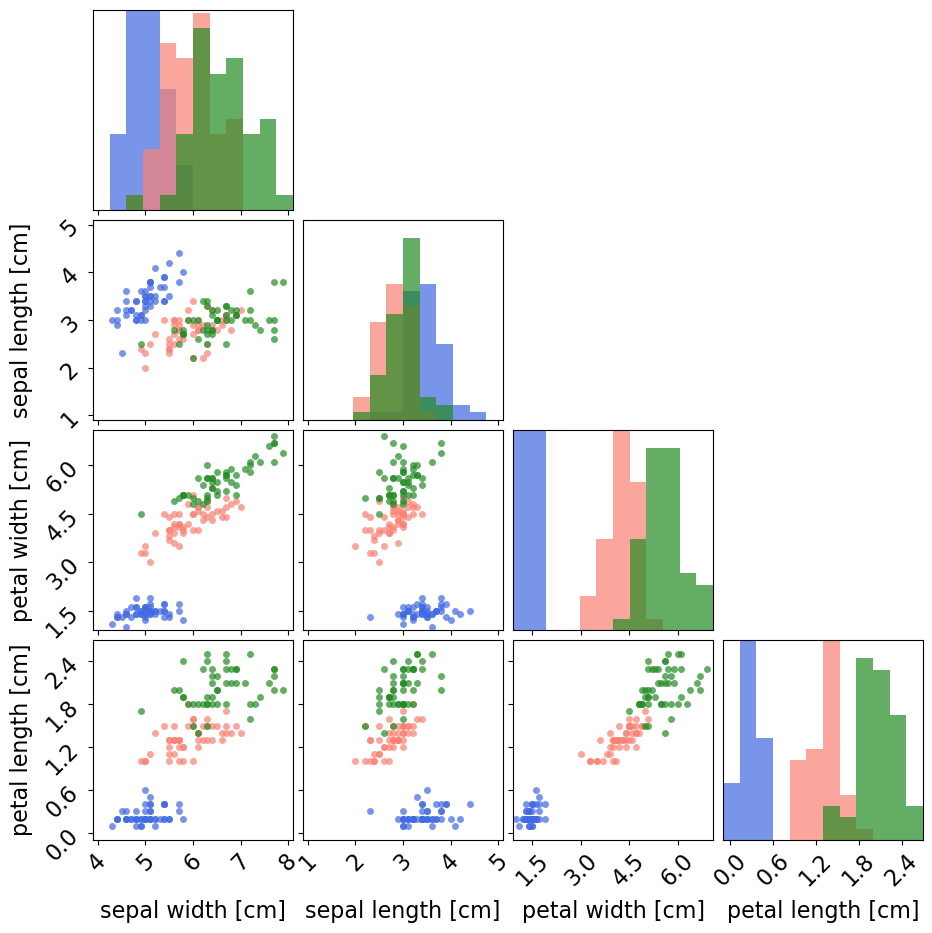

In [4]:
sepwidth, seplength, petwidth, petlength = iris_data.data.T

# fig, axes = plt.subplots(2,2, figsize=(8,8))
fig = corner(iris_data.data[iris_data.target == 0],
             labels=['sepal width [cm]', 'sepal length [cm]', 'petal width [cm]', 'petal length [cm]'],
             range=[(3.9,8.1), (0.9,5.1), (0.9,7.1), (-0.1,2.7)],
             plot_contours=False,
             plot_density=False,
             plot_datapoints=True,
             data_kwargs={'color':'RoyalBlue', 'alpha':0.7, 'ms':5},
             hist_kwargs={'histtype':'stepfilled', 'color':'RoyalBlue', 'alpha':0.7},
             bins=12)

fig = corner(iris_data.data[iris_data.target == 1],
       range=[(3.9,8.1), (0.9,5.1), (0.9,7.1), (-0.1,2.7)],
       plot_contours=False,
       plot_density=False,
       plot_datapoints=True,
       data_kwargs={'color':'Salmon', 'alpha':0.7, 'ms':5},
       hist_kwargs={'histtype':'stepfilled', 'color':'Salmon', 'alpha':0.7},
       bins=12,
       fig=fig)

fig = corner(iris_data.data[iris_data.target == 2],
       range=[(3.9,8.1), (0.9,5.1), (0.9,7.1), (-0.1,2.7)],
       plot_contours=False,
       plot_density=False,
       plot_datapoints=True,
       data_kwargs={'color':'ForestGreen', 'alpha':0.7, 'ms':5},
       hist_kwargs={'histtype':'stepfilled', 'color':'ForestGreen', 'alpha':0.7},
       bins=12,
       fig=fig)

# fig.savefig('fisher_iris.pdf')

## Model Setup

Define the training and validation data using the iris sample. You can play with the size of the validation sample to see its effect on the performance of the classifiers.

In [5]:
# X are the data, Y are the target categories (species).
X = iris_data.data
Y = iris_data.target

validation_size = 0.6
seed = 7

X_train, X_validation, Y_train, Y_validation = \
    model_selection.train_test_split(X, Y, 
                                     test_size=validation_size, 
                                     random_state=seed)

### Models

We're going to loop through a list of models imported from scikit-learn:
1. Generative classifiers:
    1. Linear discriminant analysis (LDA).
    1. K nearest neighbors (KNN).
    1. Gaussian Naive Base (NB).
1. Discriminative classifiers:
    1. Logistic regression.
    1. Support vector machine (SVM).
    1. Decision tree.
    
At the end is also a demonstration of random forest and a boosted decision tree classifiers.
    
#### Evaluation Metric

Different metrics can be used to evaluate the performance of the classifier during cross validation, e.g.
1. Accuracy
1. Precision
1. Recall
1. ...

See the [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for built-in scoring metrics. In this calculation we are going to optimize for **accuracy**.

In [6]:
# Test options and evaluation metric; in our case, accuracy.
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Linear Discriminant', LinearDiscriminantAnalysis()))
models.append(('K Nearest Neighbors', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Support Vector Machine', SVC()))

# evaluate each model in turn.
# Preprocess the training data first. See
# https://scikit-learn.org/stable/modules/preprocessing.html
X_scaled = preprocessing.scale(X_train)

results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_scaled, Y_train,
                                                 cv=kfold, 
                                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Logistic Regression: 0.966667 (0.066667)
Linear Discriminant: 0.966667 (0.066667)
K Nearest Neighbors: 0.933333 (0.081650)
Decision Tree: 0.966667 (0.066667)
Gaussian Naive Bayes: 0.950000 (0.076376)
Support Vector Machine: 0.950000 (0.076376)


### Make Predictions on Validation Data

Apply model predictions and plot confusion matrices.

Logistic Regression
0.9444444444444444
[[30  0  0]
 [ 0 26  3]
 [ 0  2 29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.93      0.90      0.91        29
           2       0.91      0.94      0.92        31

    accuracy                           0.94        90
   macro avg       0.94      0.94      0.94        90
weighted avg       0.94      0.94      0.94        90

Linear Discriminant
0.9555555555555556
[[30  0  0]
 [ 0 28  1]
 [ 0  3 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.90      0.97      0.93        29
           2       0.97      0.90      0.93        31

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90

K Nearest Neighbors
0.9111111111111111
[[30  0  0]
 [ 0 24  5]
 [ 0  3 28]]
          

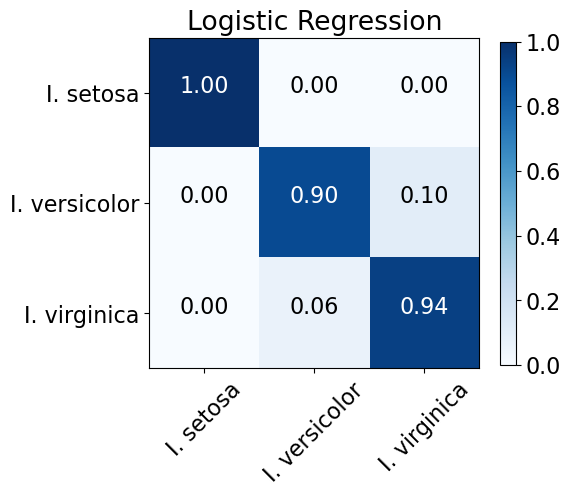

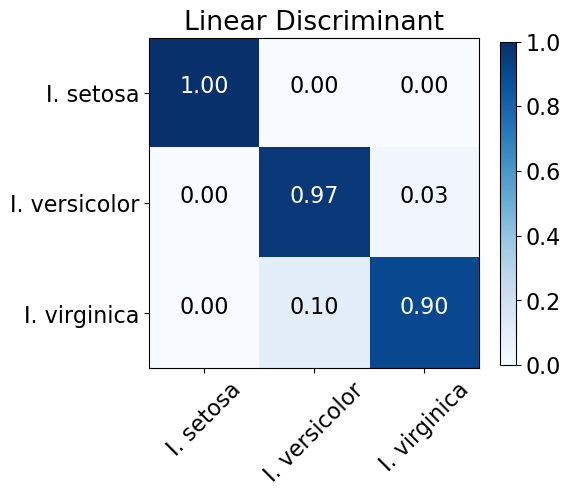

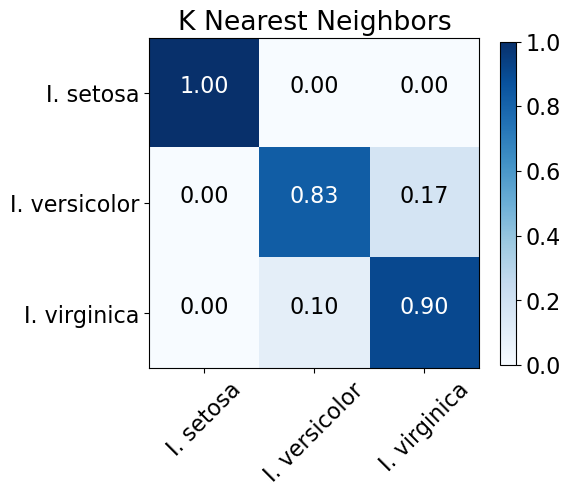

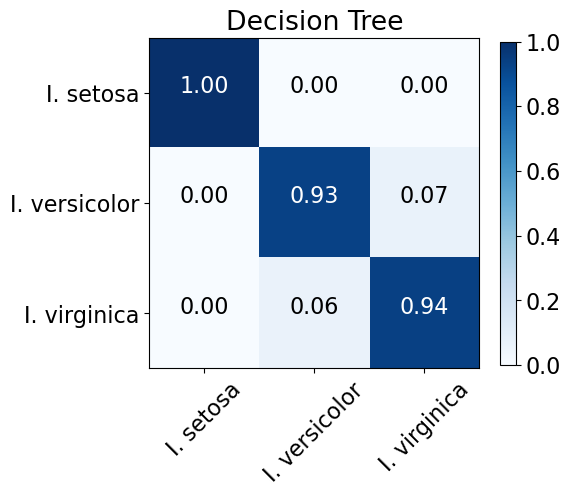

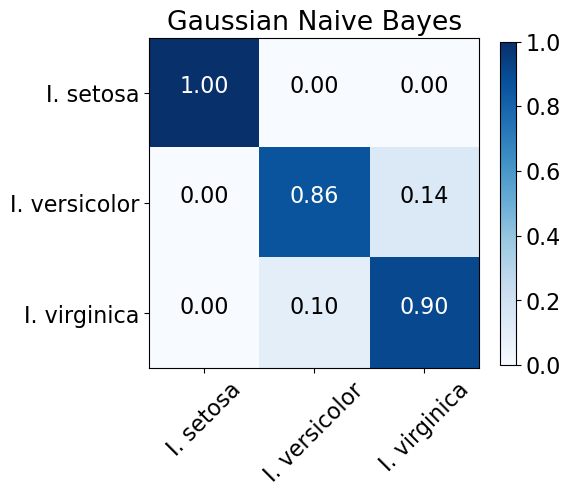

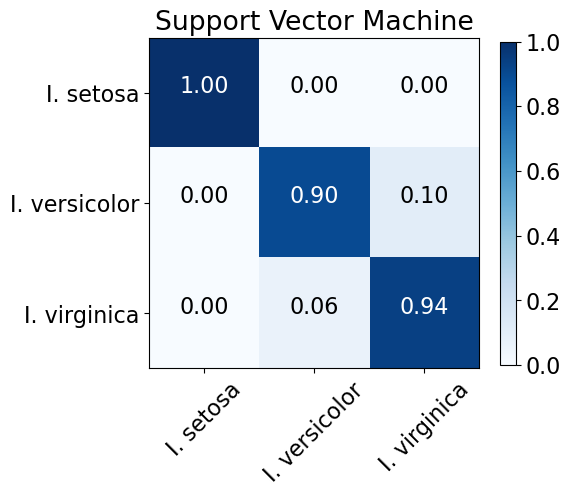

In [7]:
normalize = True

# Make predictions on validation dataset.
for name, model in models:
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    cm = confusion_matrix(Y_validation, predictions)
    
    print(name)
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    print(classification_report(Y_validation, predictions))


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(1,1, figsize=(6,6))
    img = ax.imshow(cm,
                    interpolation='nearest',
                    cmap='Blues')

    tick_marks = np.arange(len(iris_data.target_names))
    tick_names = [' '.join(['I.', x]) for x in iris_data.target_names]
    ax.set(#aspect='equal',
           xticks=tick_marks,
           xticklabels=tick_names,
           yticks=tick_marks,
           yticklabels=tick_names,
           title=name)
    fig.colorbar(img, shrink=0.675)
    plt.xticks(rotation=45)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    
    output_name = name.replace(' ', '_')
    outfile = 'iris_{:s}_cmatrix.pdf'.format(output_name)
    fig.savefig(outfile)

## Decision Boundaries

Plot decision boundaries for the classifiers.

In [8]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

## Gaussian NB Decision Boundary

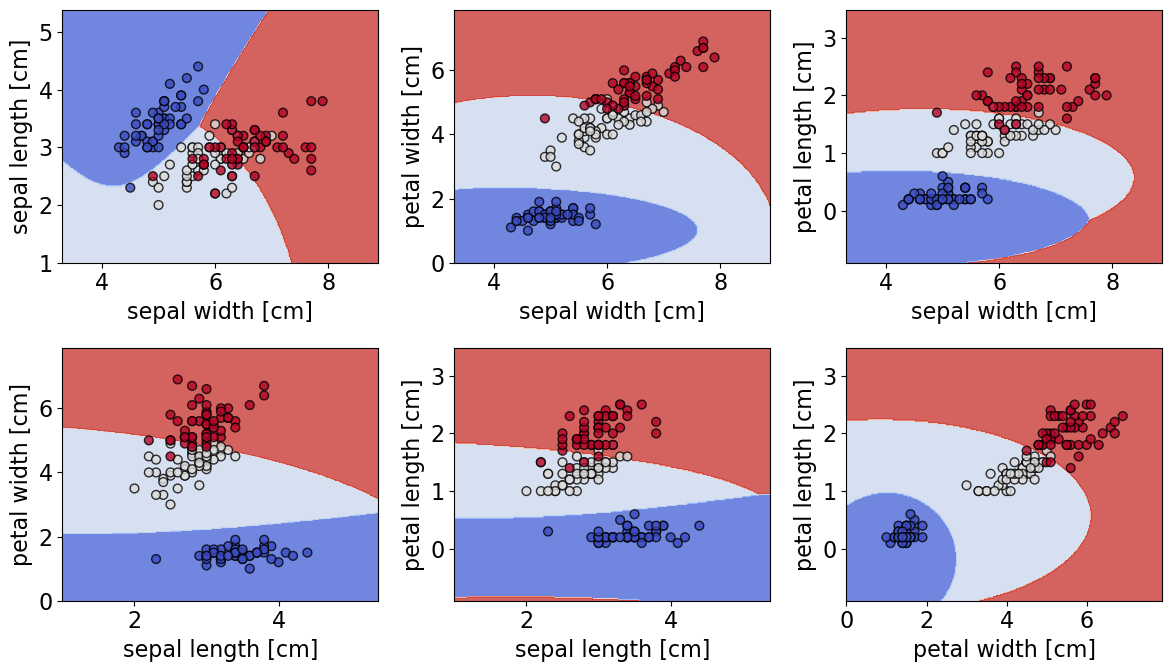

In [9]:
fig, sp = plt.subplots(2,3, figsize=(12,7))
axes = sp.flatten()
labels=['sepal width [cm]', 'sepal length [cm]', 'petal width [cm]', 'petal length [cm]']

k = 0
for i in range(3):
    for j in range(i+1,4):
        X_iris = iris_data.data[:, [i,j]]
        y_iris = iris_data.target
                
        model = GaussianNB()
        model.fit(X_iris, y_iris)

        X0, X1 = X_iris[:, 0], X_iris[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        ax = axes[k]
        plot_contours(ax, model, xx, yy, cmap='coolwarm', alpha=0.8)
        ax.scatter(X0, X1, c=y_iris, cmap='coolwarm', s=40, edgecolors='k', alpha=0.8)
        ax.set(xlabel=labels[i], ylabel=labels[j])
        k += 1
        
fig.tight_layout()
fig.savefig('iris_decision_GaussianNB.pdf')

## LDA Decision Boundary

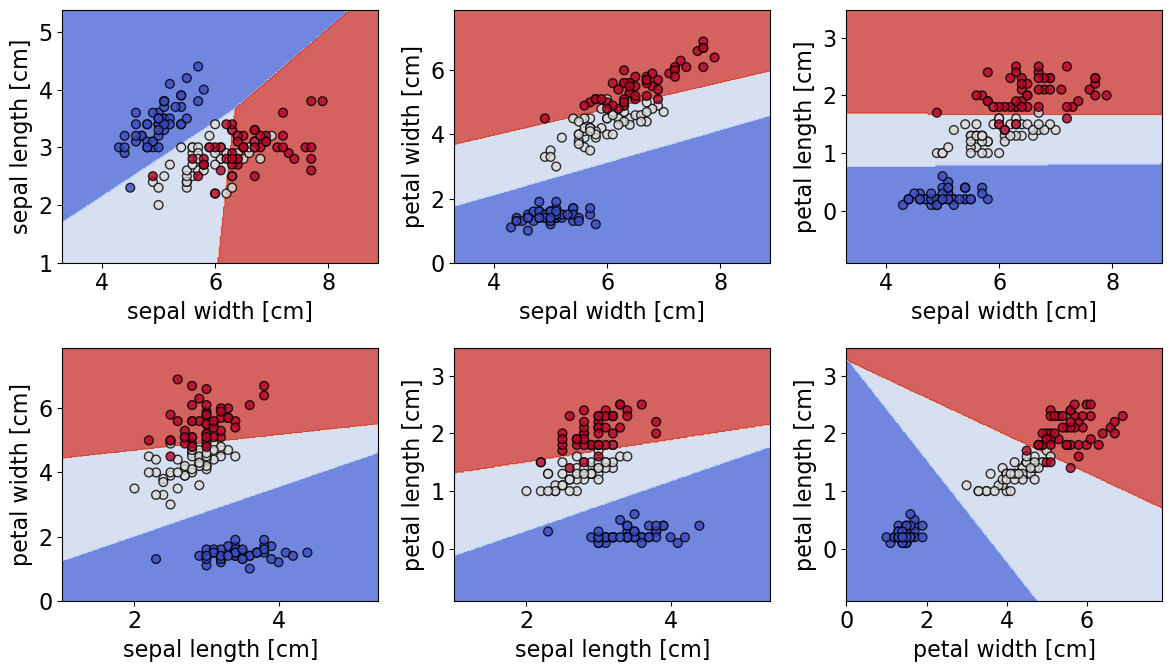

In [10]:
fig, sp = plt.subplots(2,3, figsize=(12,7))
axes = sp.flatten()
labels=['sepal width [cm]', 'sepal length [cm]', 'petal width [cm]', 'petal length [cm]']

k = 0
for i in range(3):
    for j in range(i+1,4):
        X_iris = iris_data.data[:, [i,j]]
        y_iris = iris_data.target
                
        model = LinearDiscriminantAnalysis()
        model.fit(X_iris, y_iris)

        X0, X1 = X_iris[:, 0], X_iris[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        ax = axes[k]
        plot_contours(ax, model, xx, yy, cmap='coolwarm', alpha=0.8)
        ax.scatter(X0, X1, c=y_iris, cmap='coolwarm', s=40, edgecolors='k', alpha=0.8)
        ax.set(xlabel=labels[i], ylabel=labels[j])
        k += 1
        
fig.tight_layout()
fig.savefig('iris_decision_LDA.pdf')

## K-Nearest-Neighbor Decision Boundary

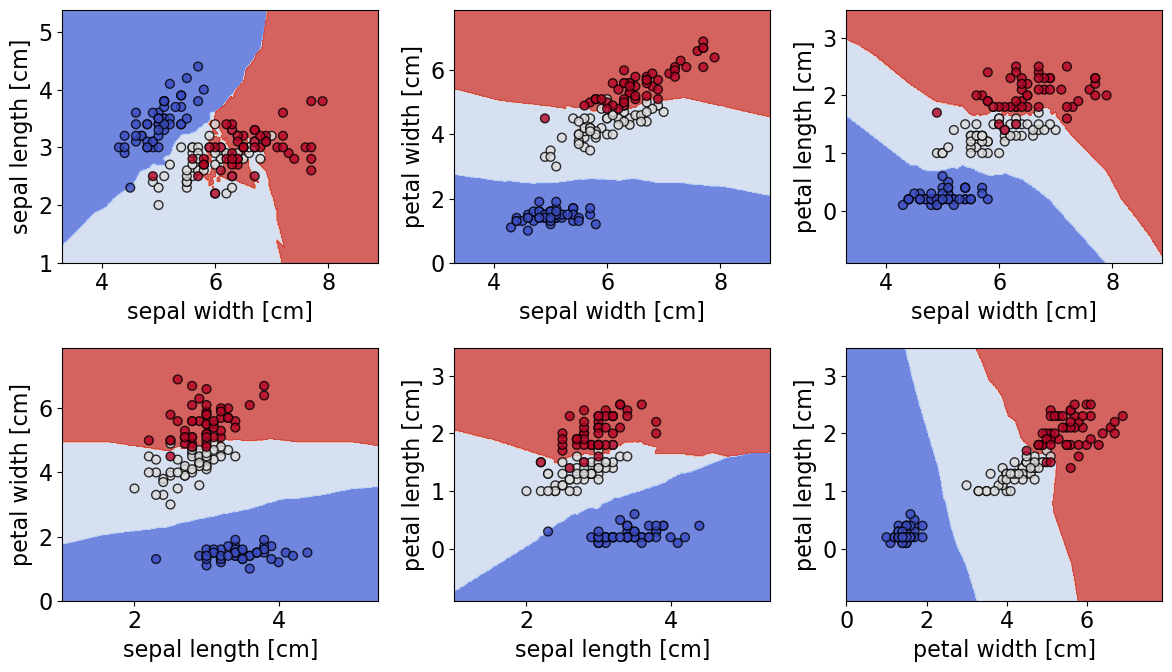

In [11]:
fig, sp = plt.subplots(2,3, figsize=(12,7))
axes = sp.flatten()
labels=['sepal width [cm]', 'sepal length [cm]', 'petal width [cm]', 'petal length [cm]']

k = 0
for i in range(3):
    for j in range(i+1,4):
        X_iris = iris_data.data[:, [i,j]]
        y_iris = iris_data.target
                
        model = KNeighborsClassifier()
        model.fit(X_iris, y_iris)

        X0, X1 = X_iris[:, 0], X_iris[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        ax = axes[k]
        plot_contours(ax, model, xx, yy, cmap='coolwarm', alpha=0.8)
        ax.scatter(X0, X1, c=y_iris, cmap='coolwarm', s=40, edgecolors='k', alpha=0.8)
        ax.set(xlabel=labels[i], ylabel=labels[j])
        k += 1
        
fig.tight_layout()
fig.savefig('iris_decision_KNN.pdf')

## Logistic Regression

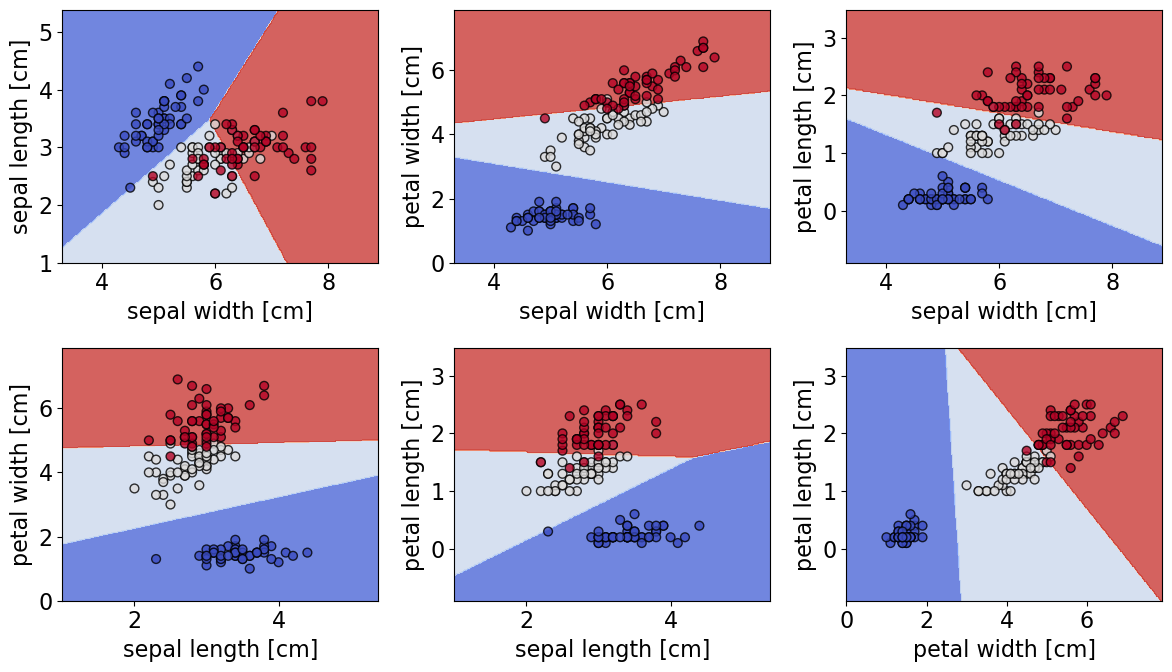

In [12]:
fig, sp = plt.subplots(2,3, figsize=(12,7))
axes = sp.flatten()
labels=['sepal width [cm]', 'sepal length [cm]', 'petal width [cm]', 'petal length [cm]']

k = 0
for i in range(3):
    for j in range(i+1,4):
        X_iris = iris_data.data[:, [i,j]]
        y_iris = iris_data.target
                
        model = LogisticRegression()
        model.fit(X_iris, y_iris)

        X0, X1 = X_iris[:, 0], X_iris[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        ax = axes[k]
        plot_contours(ax, model, xx, yy, cmap='coolwarm', alpha=0.8)
        ax.scatter(X0, X1, c=y_iris, cmap='coolwarm', s=40, edgecolors='k', alpha=0.8)
        ax.set(xlabel=labels[i], ylabel=labels[j])
        k += 1
        
fig.tight_layout()
fig.savefig('iris_decision_LR.pdf')

## Support Vector Machine

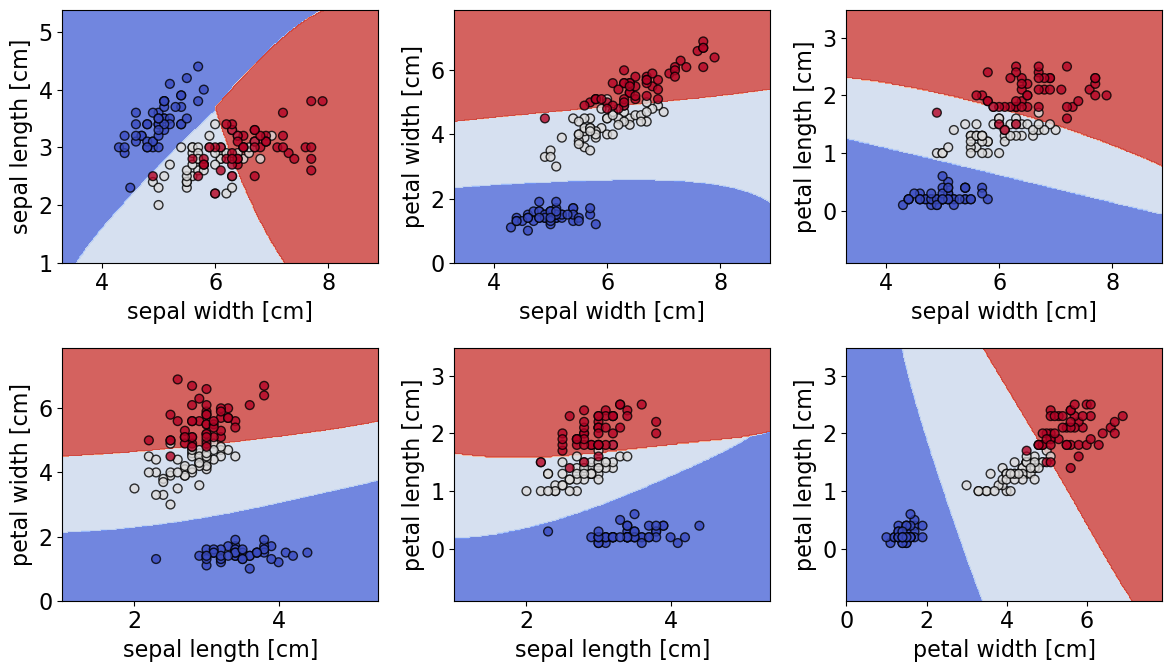

In [13]:
fig, sp = plt.subplots(2,3, figsize=(12,7))
axes = sp.flatten()
labels=['sepal width [cm]', 'sepal length [cm]', 'petal width [cm]', 'petal length [cm]']

k = 0
for i in range(3):
    for j in range(i+1,4):
        X_iris = iris_data.data[:, [i,j]]
        y_iris = iris_data.target
                
        model = SVC()
        model.fit(X_iris, y_iris)

        X0, X1 = X_iris[:, 0], X_iris[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        ax = axes[k]
        plot_contours(ax, model, xx, yy, cmap='coolwarm', alpha=0.8)
        ax.scatter(X0, X1, c=y_iris, cmap='coolwarm', s=40, edgecolors='k', alpha=0.8)
        ax.set(xlabel=labels[i], ylabel=labels[j])
        k += 1
        
fig.tight_layout()
fig.savefig('iris_decision_SVM.pdf')

## Decision Trees

Add some additional support to plot the decision tree itself.

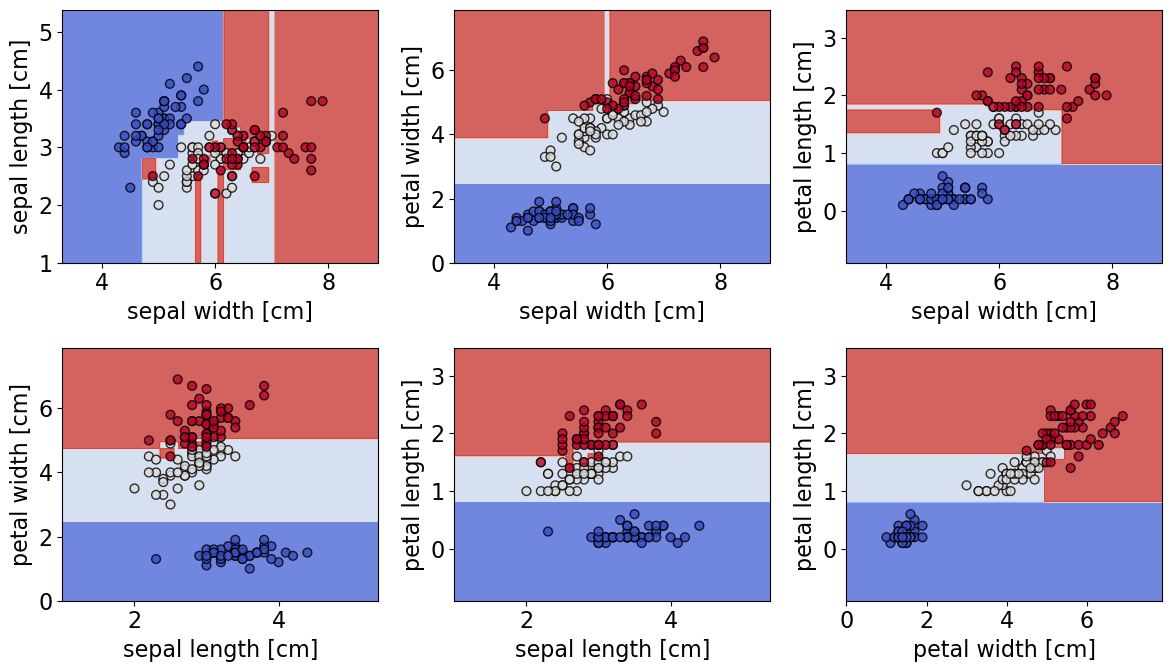

In [14]:
fig, sp = plt.subplots(2,3, figsize=(12,7))
axes = sp.flatten()
labels=['sepal width [cm]', 'sepal length [cm]', 'petal width [cm]', 'petal length [cm]']

k = 0
for i in range(3):
    for j in range(i+1,4):
        X_iris = iris_data.data[:, [i,j]]
        y_iris = iris_data.target
                
        model = DecisionTreeClassifier()
        model.fit(X_iris, y_iris)

        X0, X1 = X_iris[:, 0], X_iris[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        ax = axes[k]
        plot_contours(ax, model, xx, yy, cmap='coolwarm', alpha=0.8)
        ax.scatter(X0, X1, c=y_iris, cmap='coolwarm', s=40, edgecolors='k', alpha=0.8)
        ax.set(xlabel=labels[i], ylabel=labels[j])
        k += 1
        
fig.tight_layout()
fig.savefig('iris_decision_DT.pdf')

In [15]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=iris_data.feature_names[2:],
                class_names=iris_data.target_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())
graph.write_pdf('dtree.pdf')

ModuleNotFoundError: No module named 'sklearn.externals.six'

## Random Forest

In [ ]:
fig, sp = plt.subplots(2,3, figsize=(12,7))
axes = sp.flatten()
labels=['sepal width [cm]', 'sepal length [cm]', 'petal width [cm]', 'petal length [cm]']

k = 0
for i in range(3):
    for j in range(i+1,4):
        X_iris = iris_data.data[:, [i,j]]
        y_iris = iris_data.target
                
        model = RandomForestClassifier(300)
        model.fit(X_iris, y_iris)

        X0, X1 = X_iris[:, 0], X_iris[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        ax = axes[k]
        plot_contours(ax, model, xx, yy, cmap='coolwarm', alpha=0.8)
        ax.scatter(X0, X1, c=y_iris, cmap='coolwarm', s=40, edgecolors='k', alpha=0.8)
        ax.set(xlabel=labels[i], ylabel=labels[j])
        k += 1
        
fig.tight_layout()
fig.savefig('iris_decision_RandomForest.pdf')

## Boosted Decision Tree

In [ ]:
fig, sp = plt.subplots(2,3, figsize=(12,7))
axes = sp.flatten()
labels=['sepal width [cm]', 'sepal length [cm]', 'petal width [cm]', 'petal length [cm]']

k = 0
for i in range(3):
    for j in range(i+1,4):
        X_iris = iris_data.data[:, [i,j]]
        y_iris = iris_data.target
                
        model = GradientBoostingClassifier()
        model.fit(X_iris, y_iris)

        X0, X1 = X_iris[:, 0], X_iris[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        ax = axes[k]
        plot_contours(ax, model, xx, yy, cmap='coolwarm', alpha=0.8)
        ax.scatter(X0, X1, c=y_iris, cmap='coolwarm', s=40, edgecolors='k', alpha=0.8)
        ax.set(xlabel=labels[i], ylabel=labels[j])
        k += 1
        
fig.tight_layout()
# fig.savefig('iris_decision_RandomForest.pdf')

In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the dataset (replace 'data.csv' with your actual dataset file)
data = pd.read_csv('data.csv')

# Separate the features (input variables) and the target variable
X = data.drop('galaxy_type', axis=1)  # Features
y = data['galaxy_type']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'